In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ! scp -r arnab_sen_sharma@compute.safe.ai:/data/arnab_sen_sharma/Projects/relations/results ../../

In [3]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json

In [4]:
############################################
sweep_root = "../../results/sweep-test"
model_name = "gptj"
############################################

sweep_path = f"{sweep_root}/{model_name}"

In [5]:
from scripts.efficacy_baselines import read_sweep_results, parse_results

In [43]:
def plot_layerwise(canvas, relation_result, attribute = "recall", best_criterion = "faithfulness"):
    by_layer = relation_result.by_layer()

    layers = list(by_layer.keys())
    value_means = [value.__dict__[attribute].mean for value in by_layer.values()]
    value_stds = [value.__dict__[attribute].stdev for value in by_layer.values()]

    if(best_criterion == "faithfulness"):
        best_layer = relation_result.best_by_faithfulness()
    elif(best_criterion == "efficacy"):
        best_layer = relation_result.best_by_efficacy()
    canvas.scatter([layers.index(best_layer.layer)], [best_layer.__dict__[attribute].mean], color="red", s=200)
    canvas.plot(range(len(layers)), value_means, color='darkblue', linewidth=3)
    canvas.fill_between(range(len(layers)), np.array(value_means) - np.array(value_stds), np.array(value_means) + np.array(value_stds), color='lightblue', alpha=0.5)

    if attribute in ["recall", "efficacy"]:
        canvas.set_ylim(0, 1)
    else:
        canvas.set_ylim(bottom=0)
    canvas.set_xlabel("Layer")
    canvas.set_ylabel(attribute)
    canvas.set_xticks(range(len(layers)), layers, rotation=90)
    test_samples = [trial.n_test_samples for trial in relation_result.trials]
    canvas.set_title(f"{relation_result.relation_name} {test_samples}\n{best_criterion} => h_layer: {best_layer.layer}, beta: {best_layer.beta.mean:.2f}, rank: {best_layer.rank.mean:.2f}, efficacy: {best_layer.efficacy.mean:.2f}")
    
    return canvas

In [7]:
sweep_results = read_sweep_results(sweep_path)

list(sweep_results.keys())

['work location']

In [8]:
# dataset = data.load_dataset()
# all_relations = [
#     relation.name for relation in dataset.relations
# ]
# all_relations = sorted(all_relations)
# # all_relations
# failed_relations = list(set(all_relations) - set(sweep_results.keys()))
# failed_relations = sorted(failed_relations)
# failed_relations

In [9]:
############################################
efficacy_root = "../../results/efficacy_baselines-test"
############################################

efficacy_path = f"{efficacy_root}/{model_name}"

In [36]:
from scripts.efficacy_baselines import (
    EfficacyBaselineLayerResult,
    EfficacyBaselineTrialResult,
    EfficacyBaselineRelationResult
)

def read_efficacy_baseline_results(sweep_path):
    efficacy_baseline_results = {}

    for relation_folder in os.listdir(sweep_path):
        cur_sweep = f"{sweep_path}/{relation_folder}"
        if "results_all.json" not in os.listdir(cur_sweep):
            continue
        with open(f"{cur_sweep}/results_all.json") as f:
            res = json.load(f)["relations"]
            if(len(res) == 0 or len(res[0]["trials"]) ==  0):
                continue
            res = res[0]
            efficacy_baseline_results[res["relation_name"]] = res
    return efficacy_baseline_results

efficacy_baseline_results = read_efficacy_baseline_results(efficacy_path)

print(len(efficacy_baseline_results))
list(efficacy_baseline_results.keys())

1


['work location']

In [37]:
from src.metrics import AggregateMetric

In [38]:
def parse_efficacy_baseline_results(efficacy_result):
    layerwise_results = {}
    for trial in efficacy_result["trials"]:
        for layer in trial["layerwise_baseline_results"]:
            layer_name = layer["layer"]
            if layer_name not in layerwise_results:
                layerwise_results[layer_name] = {
                    edit_type: [] for edit_type in layer["results"].keys()
                }
                layerwise_results[layer_name]
            for edit_type in layer["results"].keys():
                layerwise_results[layer_name][edit_type].append(layer['results'][edit_type])
    
    for layer_name in layerwise_results.keys():
        for edit_type in layerwise_results[layer_name].keys():
            layerwise_results[layer_name][edit_type] = AggregateMetric.aggregate(layerwise_results[layer_name][edit_type])
        
    return {
        "relation_name": efficacy_result["relation_name"],
        "layerwise_result": layerwise_results
    }


parse_efficacy_baseline_results(
    efficacy_baseline_results["work location"]
)

{'relation_name': 'work location',
 'layerwise_result': {'emb': {'hidden_baseline': AggregateMetric(mean=0.6297101449275363, stdev=0.09867319755629708, stderr=0.05696899717092924, values=[0.65, 0.7391304347826086, 0.5]),
   'embed_baseline': AggregateMetric(mean=0.016666666666666666, stdev=0.023570226039551587, stderr=0.013608276348795436, values=[0.05, 0.0, 0.0]),
   'low_rank_pinv': AggregateMetric(mean=0.7182769726247987, stdev=0.054209103088148095, stderr=0.03129764026047048, values=[0.65, 0.782608695652174, 0.7222222222222222]),
   'hidden_baseline_z': AggregateMetric(mean=0.3534621578099839, stdev=0.32394977662516744, stderr=0.18703249073845957, values=[0.0, 0.782608695652174, 0.2777777777777778])},
  2: {'hidden_baseline': AggregateMetric(mean=0.966988727858293, stdev=0.023857540080562085, stderr=0.013774157187714806, values=[1.0, 0.9565217391304348, 0.9444444444444444]),
   'embed_baseline': AggregateMetric(mean=0.2357487922705314, stdev=0.06981971696672334, stderr=0.0403104323

In [39]:
# relation_result.by_layer()

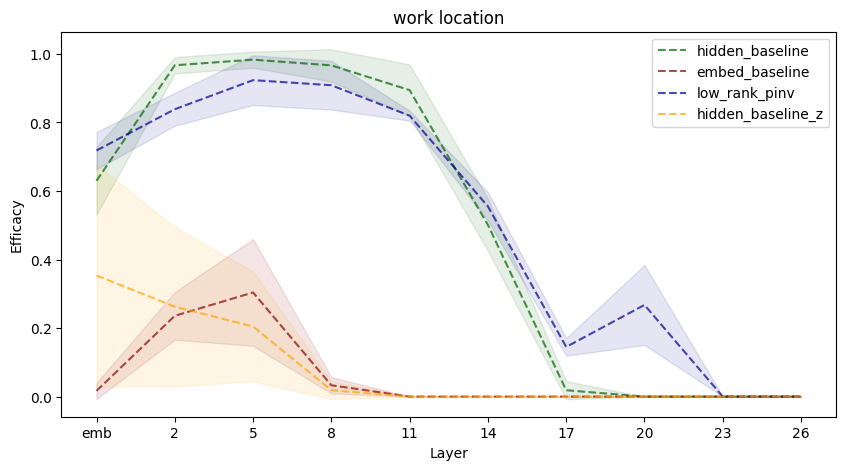

In [40]:
color_dict = {
    "low_rank_pinv": "darkblue",
    "hidden_baseline": "darkgreen",
    "embed_baseline": "darkred",
    "hidden_baseline_z": "orange"
}

def plot_efficacy_baseline(ax, efficacy_result):
    layerwise_result = efficacy_result["layerwise_result"]
    layers = list(layerwise_result.keys())
    edit_types = list(layerwise_result[layers[0]].keys())

    for edit_type in edit_types:
        ax.plot(
            range(len(layers)),
            [layerwise_result[layer][edit_type].mean for layer in layers],
            label=edit_type,
            color=color_dict[edit_type],
            alpha=0.7,
            linestyle='--'
        )
        ax.fill_between(
            range(len(layers)),
            [layerwise_result[layer][edit_type].mean - layerwise_result[layer][edit_type].stdev for layer in layers],
            [layerwise_result[layer][edit_type].mean + layerwise_result[layer][edit_type].stdev for layer in layers],
            alpha=0.1,
            color=color_dict[edit_type]
        )
    ax.set_xticks(range(len(layers)))
    ax.set_xticklabels(layers)
    ax.legend()
    ax.set_xlabel("Layer")
    ax.set_ylabel("Efficacy")
    if(ax.get_title() == ""):
        ax.set_title(efficacy_result["relation_name"])



efficacy_result = parse_efficacy_baseline_results(
    efficacy_baseline_results["work location"]
)

fig, ax = plt.subplots(figsize=(10, 5))
plot_efficacy_baseline(ax, efficacy_result)

/tmp/ipykernel_98554/114438650.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


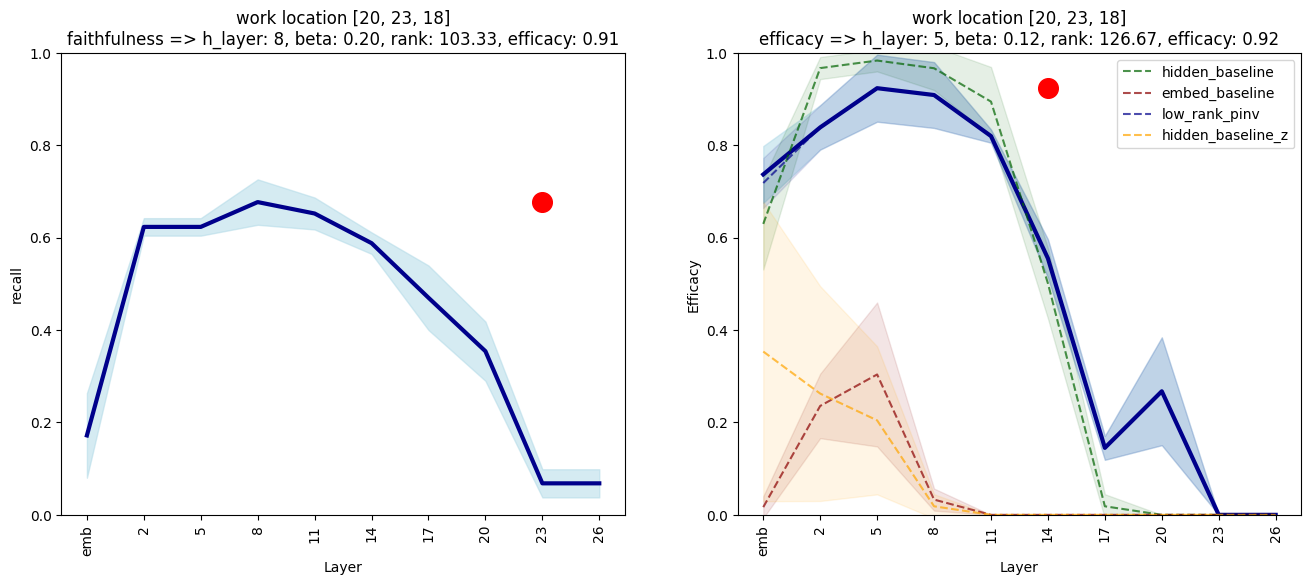

In [41]:
relation_result = parse_results(sweep_results['work location'])

nrows = 1
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6))

plot_layerwise(ax[0], relation_result)
plot_layerwise(ax[1], relation_result, attribute="efficacy", best_criterion="efficacy")
plot_efficacy_baseline(ax[1], efficacy_result)

fig.show()

In [42]:
ranks = {
    layer : layer_summary.rank.values
    for layer, layer_summary in relation_result.by_layer().items()
}
ranks

{'emb': [90, 200, 170],
 2: [110, 90, 100],
 5: [170, 120, 90],
 8: [130, 90, 90],
 11: [70, 60, 100],
 14: [70, 50, 40],
 17: [60, 40, 30],
 20: [150, 80, 60],
 23: [0, 0, 0],
 26: [0, 0, 0]}

In [29]:

relation_result.trials[0].layers[0].result.best_rank()

SweepRankResults(rank=90, efficacy=0.65, efficacy_successes=[EfficacyTestPair(source=RelationSample(subject='accountant', object='office'), target=RelationSample(subject='teacher', object='school')), EfficacyTestPair(source=RelationSample(subject='barber', object='barbershop'), target=RelationSample(subject='scientist', object='laboratory')), EfficacyTestPair(source=RelationSample(subject='farmer', object='farm'), target=RelationSample(subject='barber', object='barbershop')), EfficacyTestPair(source=RelationSample(subject='florist', object='flower shop'), target=RelationSample(subject='trainer', object='gym')), EfficacyTestPair(source=RelationSample(subject='historian', object='library'), target=RelationSample(subject='teacher', object='school')), EfficacyTestPair(source=RelationSample(subject='librarian', object='library'), target=RelationSample(subject='firefighter', object='fire station')), EfficacyTestPair(source=RelationSample(subject='mechanic', object='garage'), target=RelationS

In [16]:
dataset = data.load_dataset()
interested_dataset = dataset.filter(
    # relation_type = ["factual"]
)

filtered_results = {}
for relation in interested_dataset.relations:
    if relation.name not in sweep_results:
        continue
    relation_result = parse_results(sweep_results[relation.name])
    if len(relation_result.trials) < 3:
        print(f"skipping {relation.name}, not enough trials, : {[trial.n_test_samples for trial in relation_result.trials]}")
        continue
    filtered_results[relation.name] = relation_result

skipping fruit outside color, not enough trials, : []
skipping company CEO, not enough trials, : [6]
skipping person father, not enough trials, : []
skipping person mother, not enough trials, : [10]
skipping person university, not enough trials, : []
skipping president birth year, not enough trials, : []
skipping superhero archnemesis, not enough trials, : []
skipping word last letter, not enough trials, : [10]


In [17]:
len(filtered_results)

35

0 name birthplace
1 name religion
2 occupation age
3 occupation gender
4 fruit inside color


/tmp/ipykernel_90692/3837948255.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


5 object superclass
6 substance phase of matter
7 task person type
8 task done by tool
9 word sentiment
10 work location
11 city in country
12 company hq
13 country capital city
14 country currency
15 country language
16 country largest city
17 food from country
18 landmark in country
19 landmark on continent
20 person lead singer of band
21 person occupation
22 person plays instrument
23 person sport position
24 plays pro sport
25 pokemon evolution
26 president election year
27 product by company
28 star constellation name
29 superhero person
30 adjective antonym
31 adjective comparative
32 adjective superlative
33 verb past tense
34 word first letter


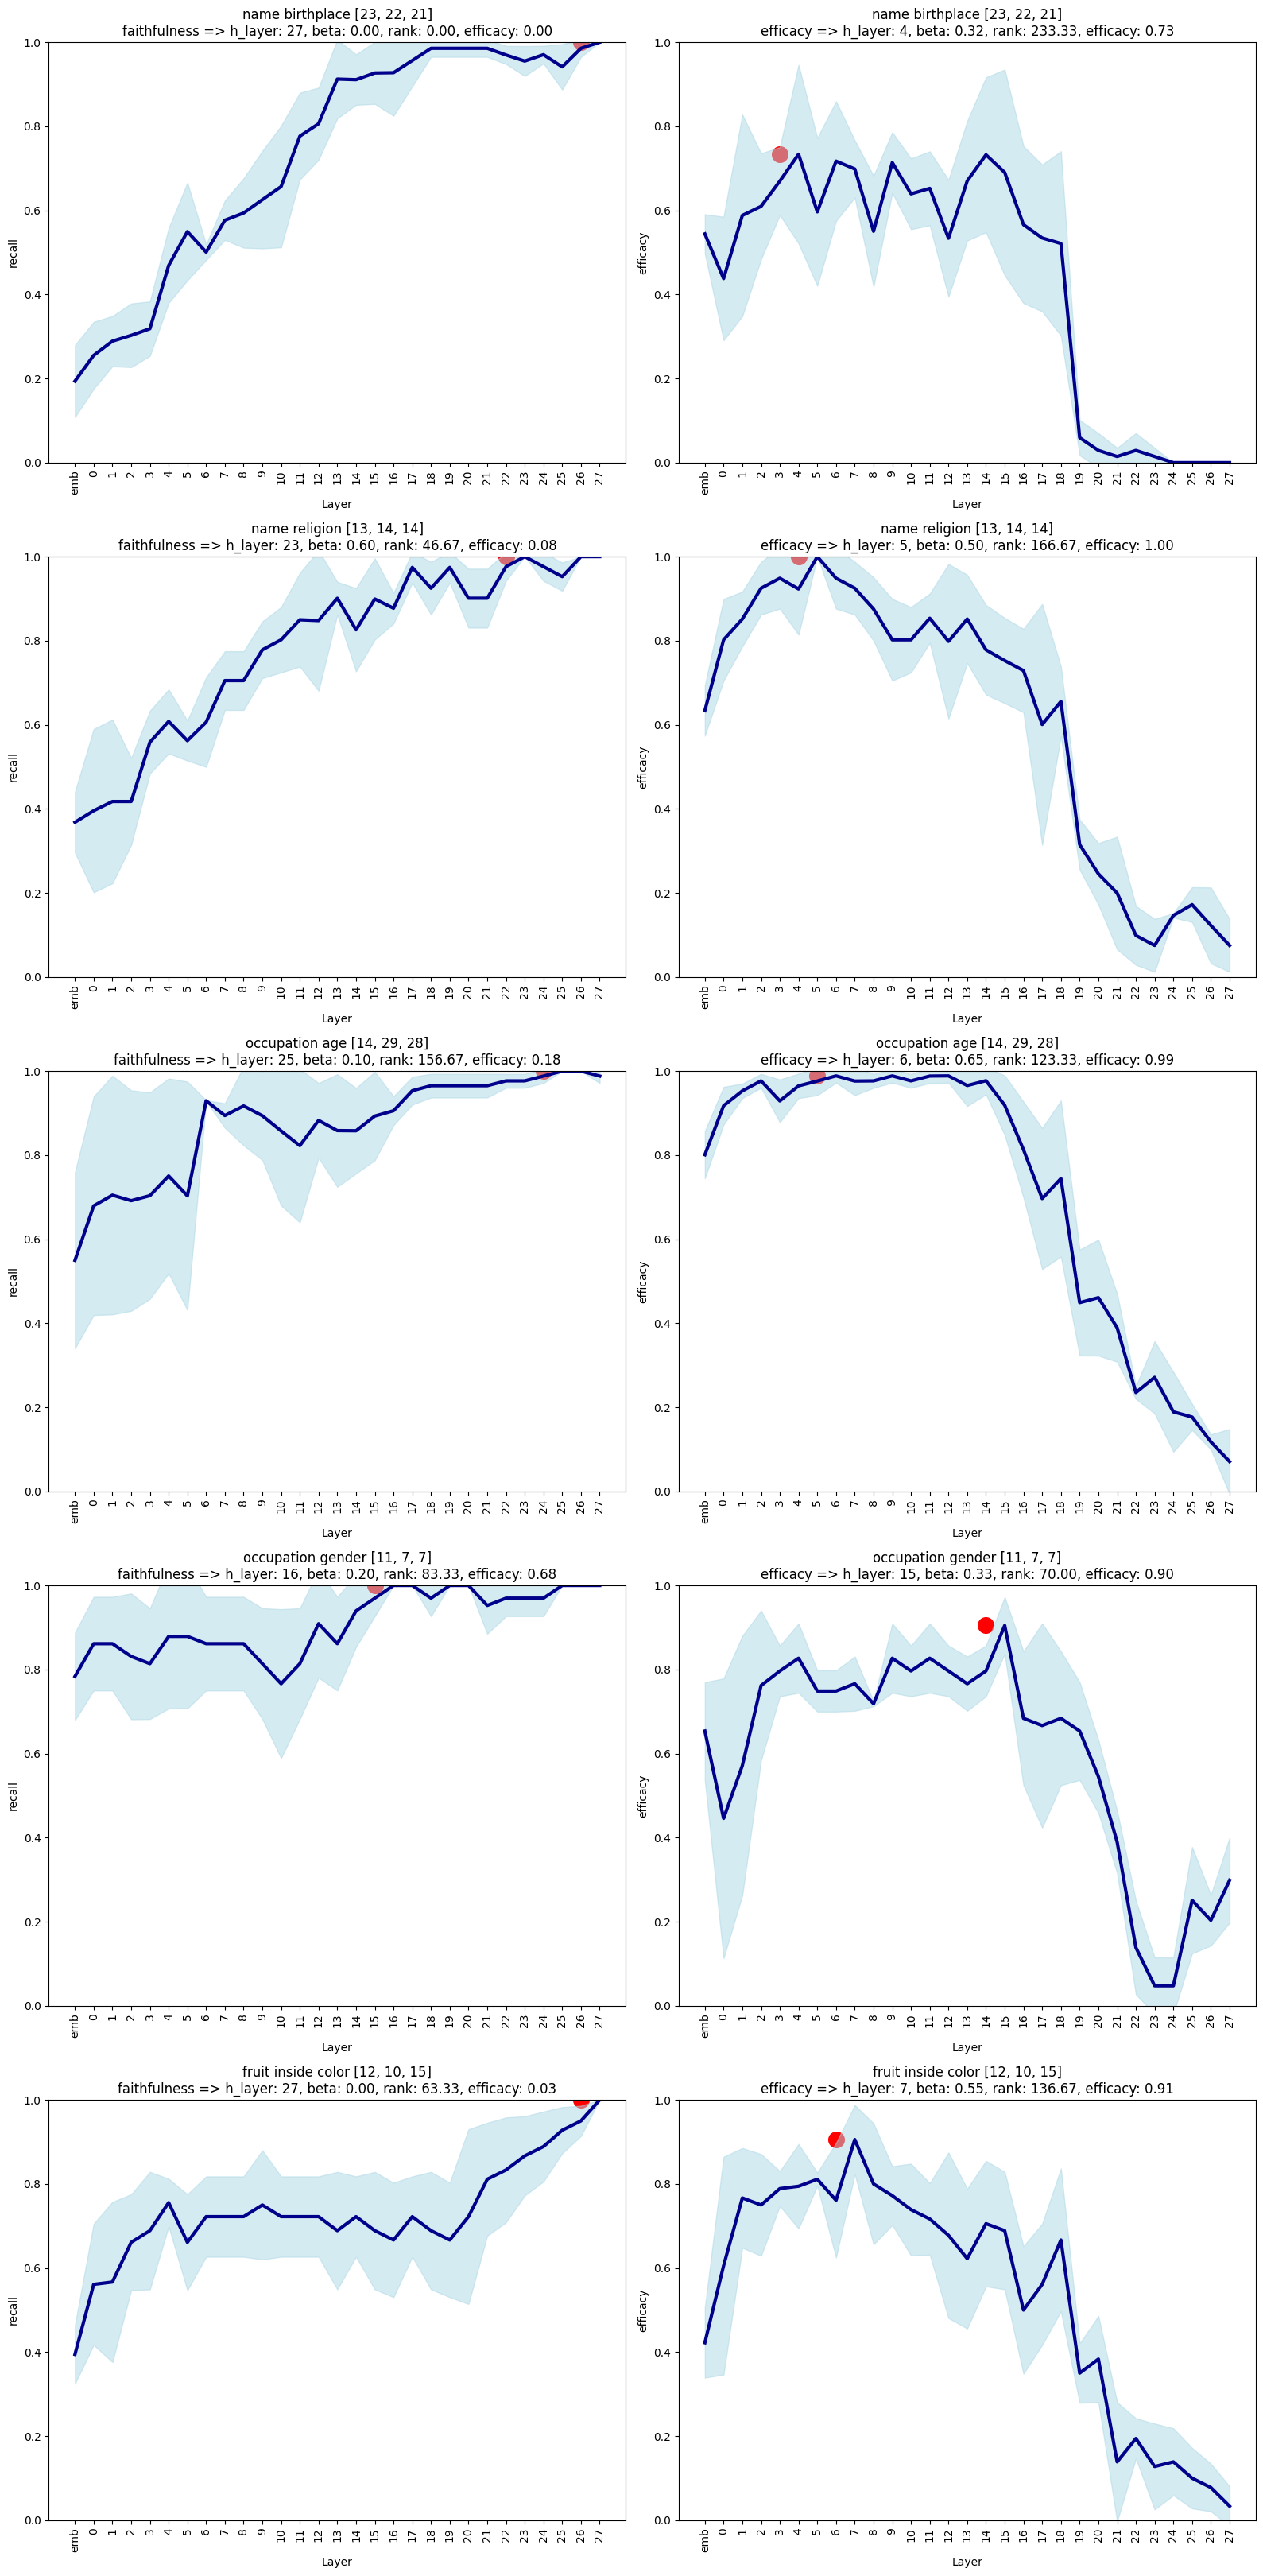

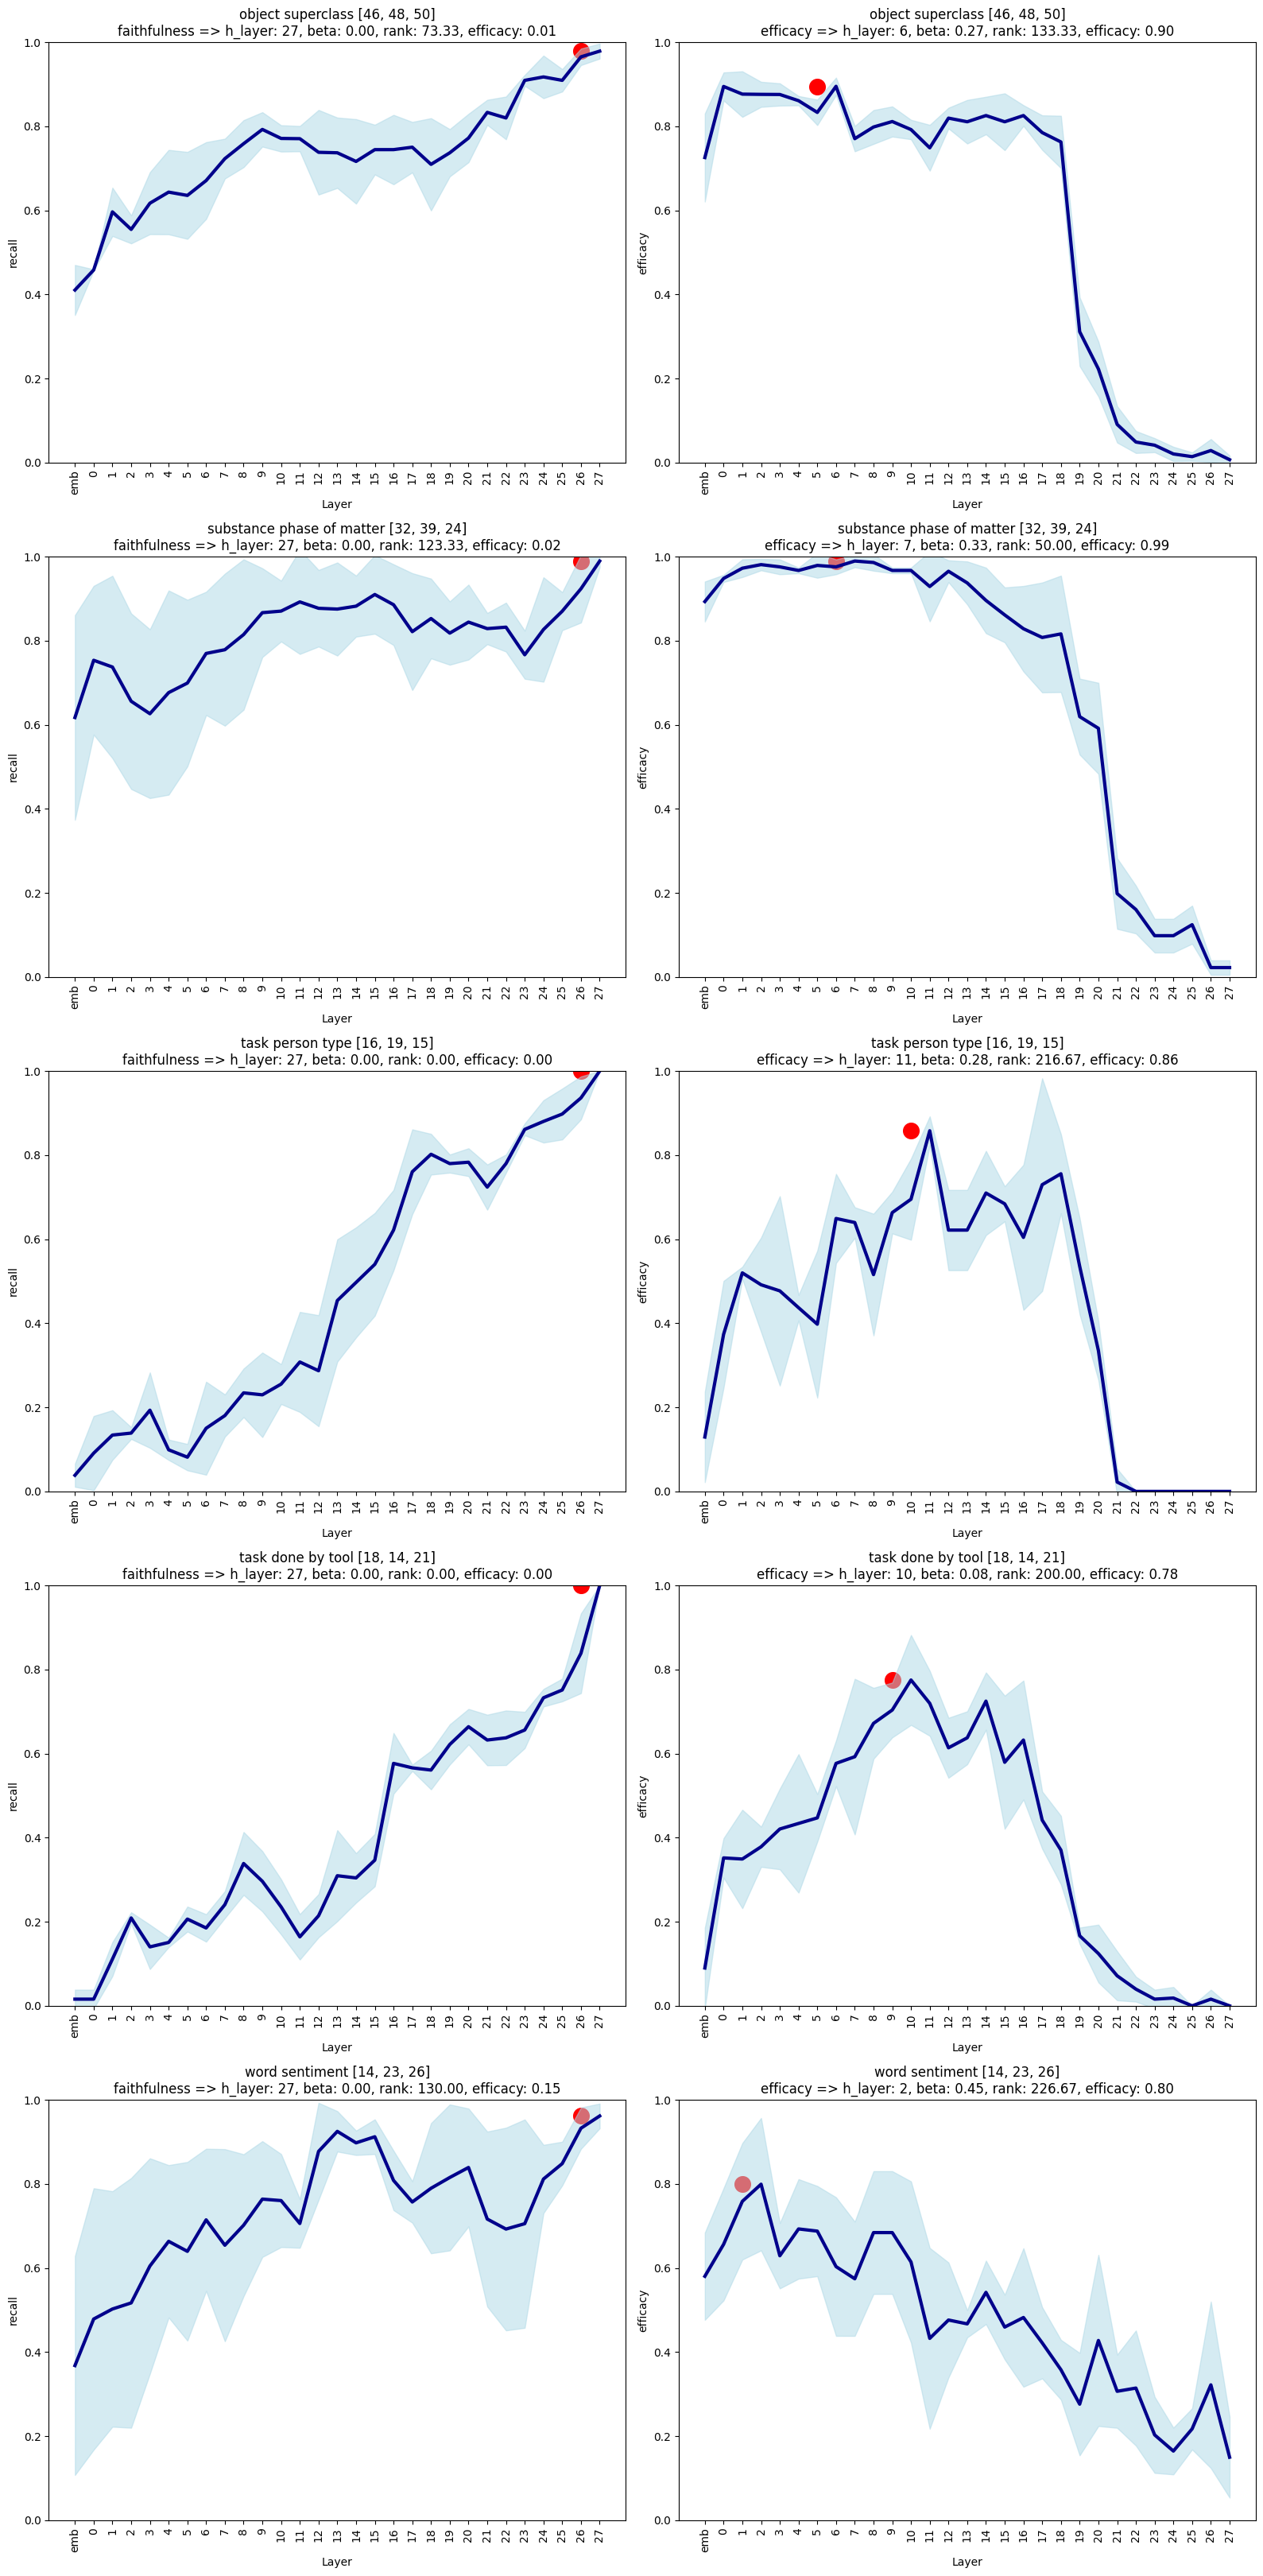

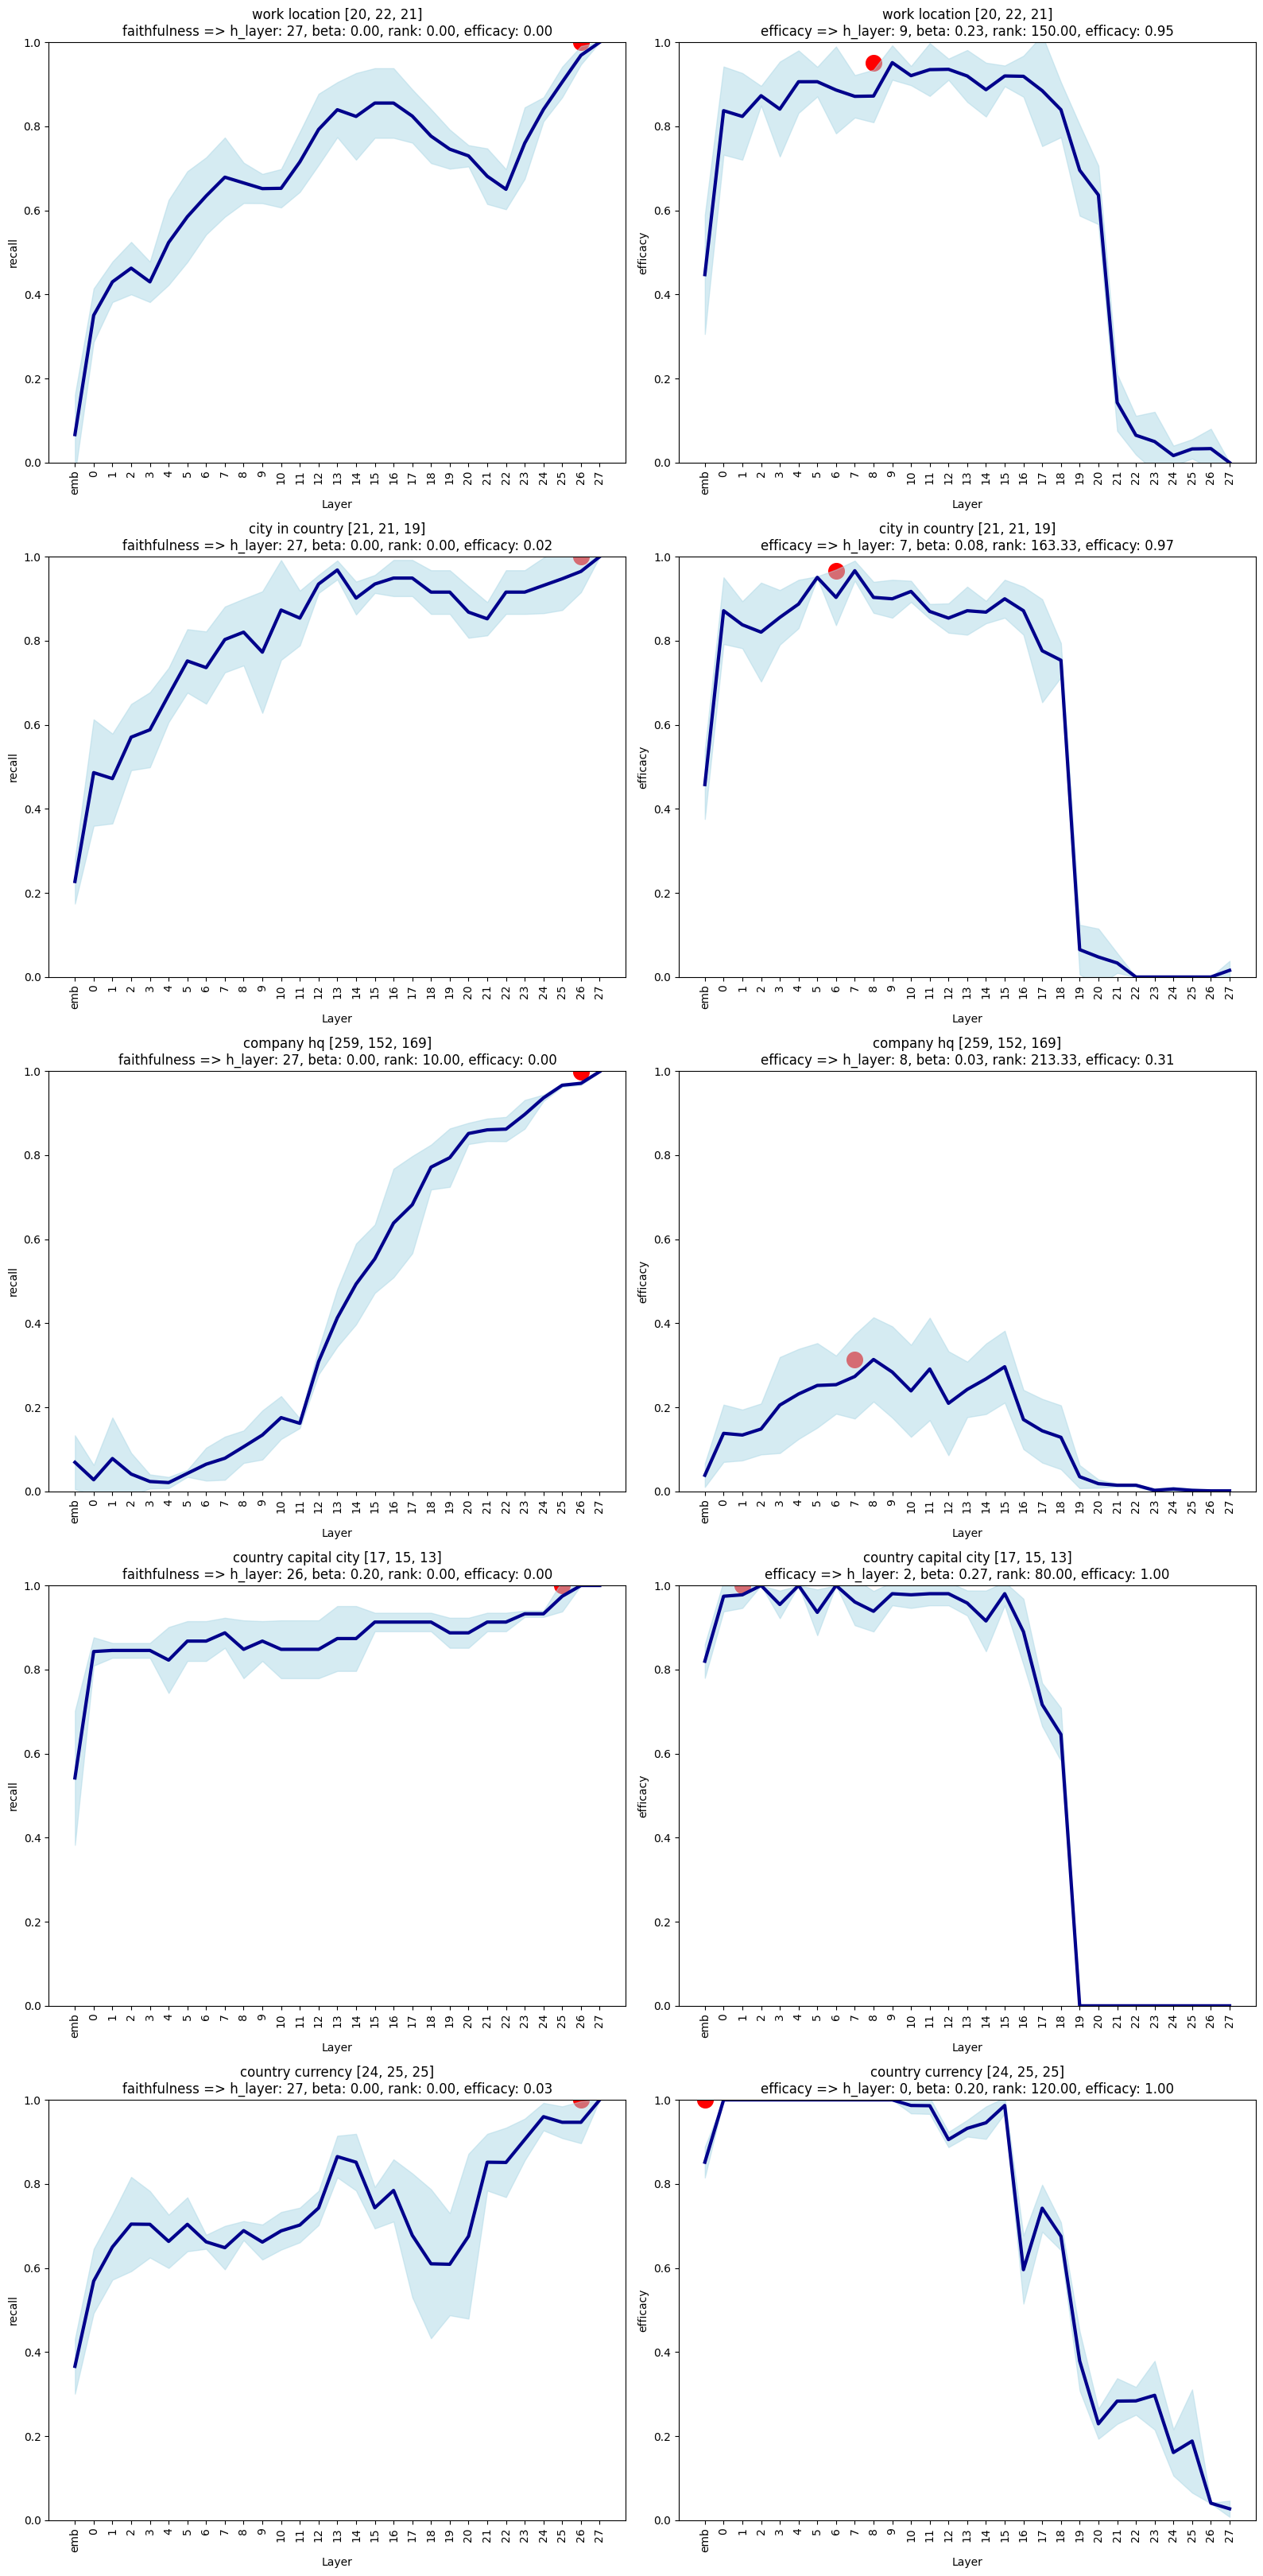

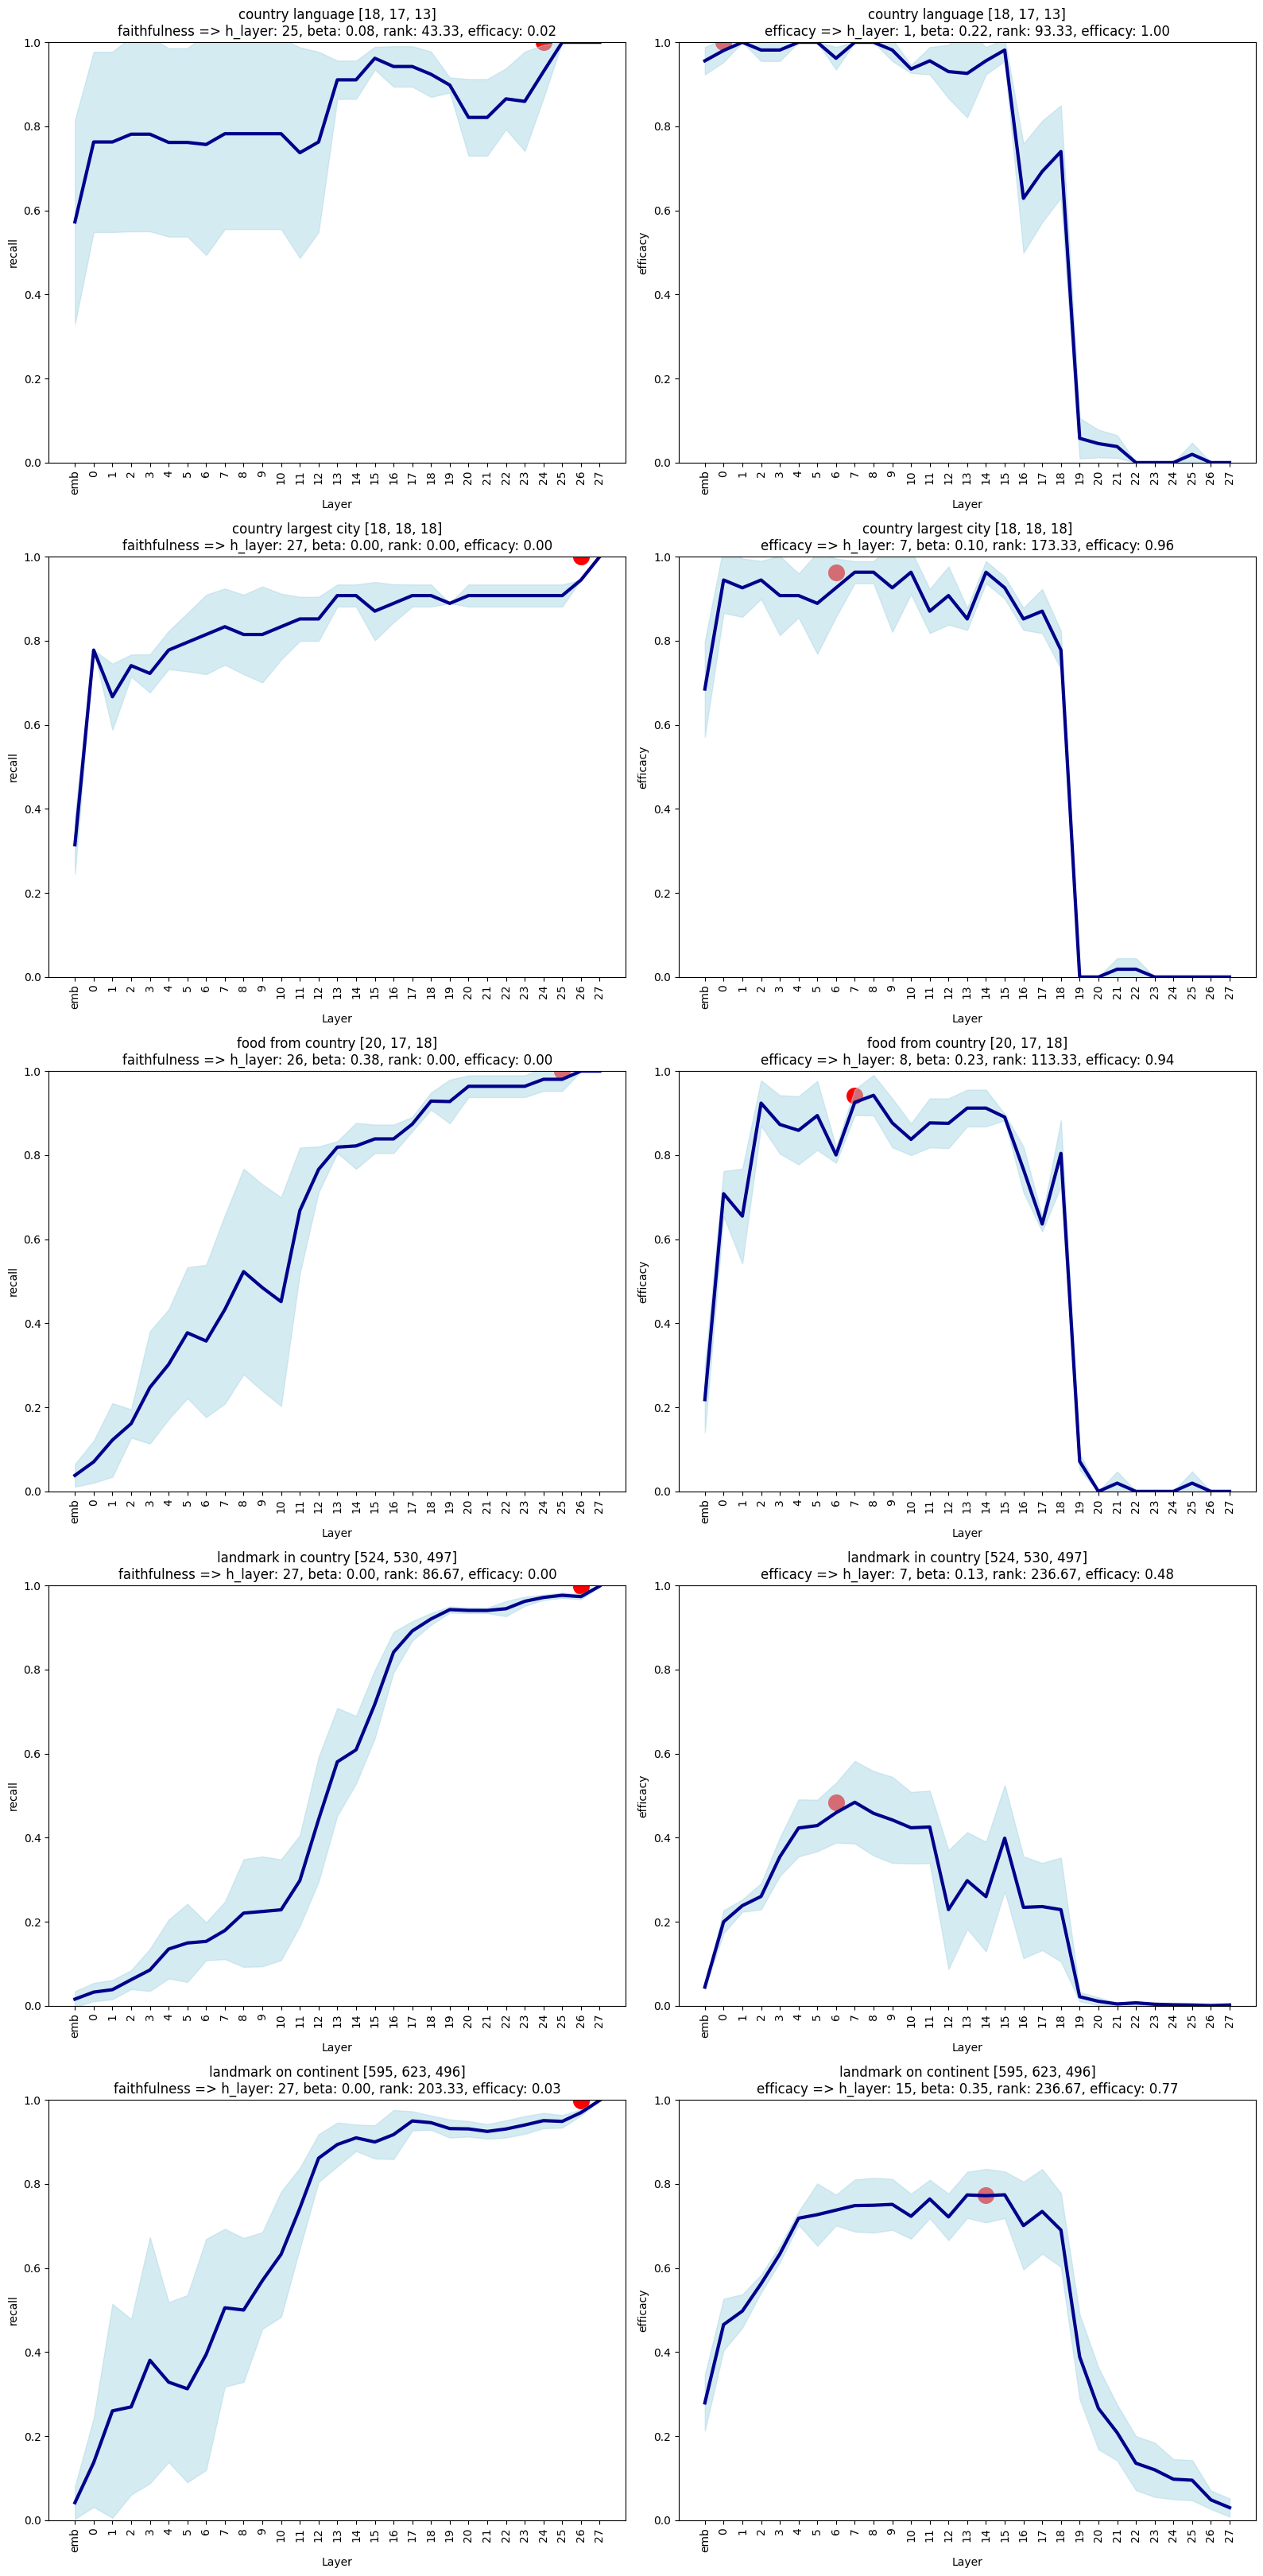

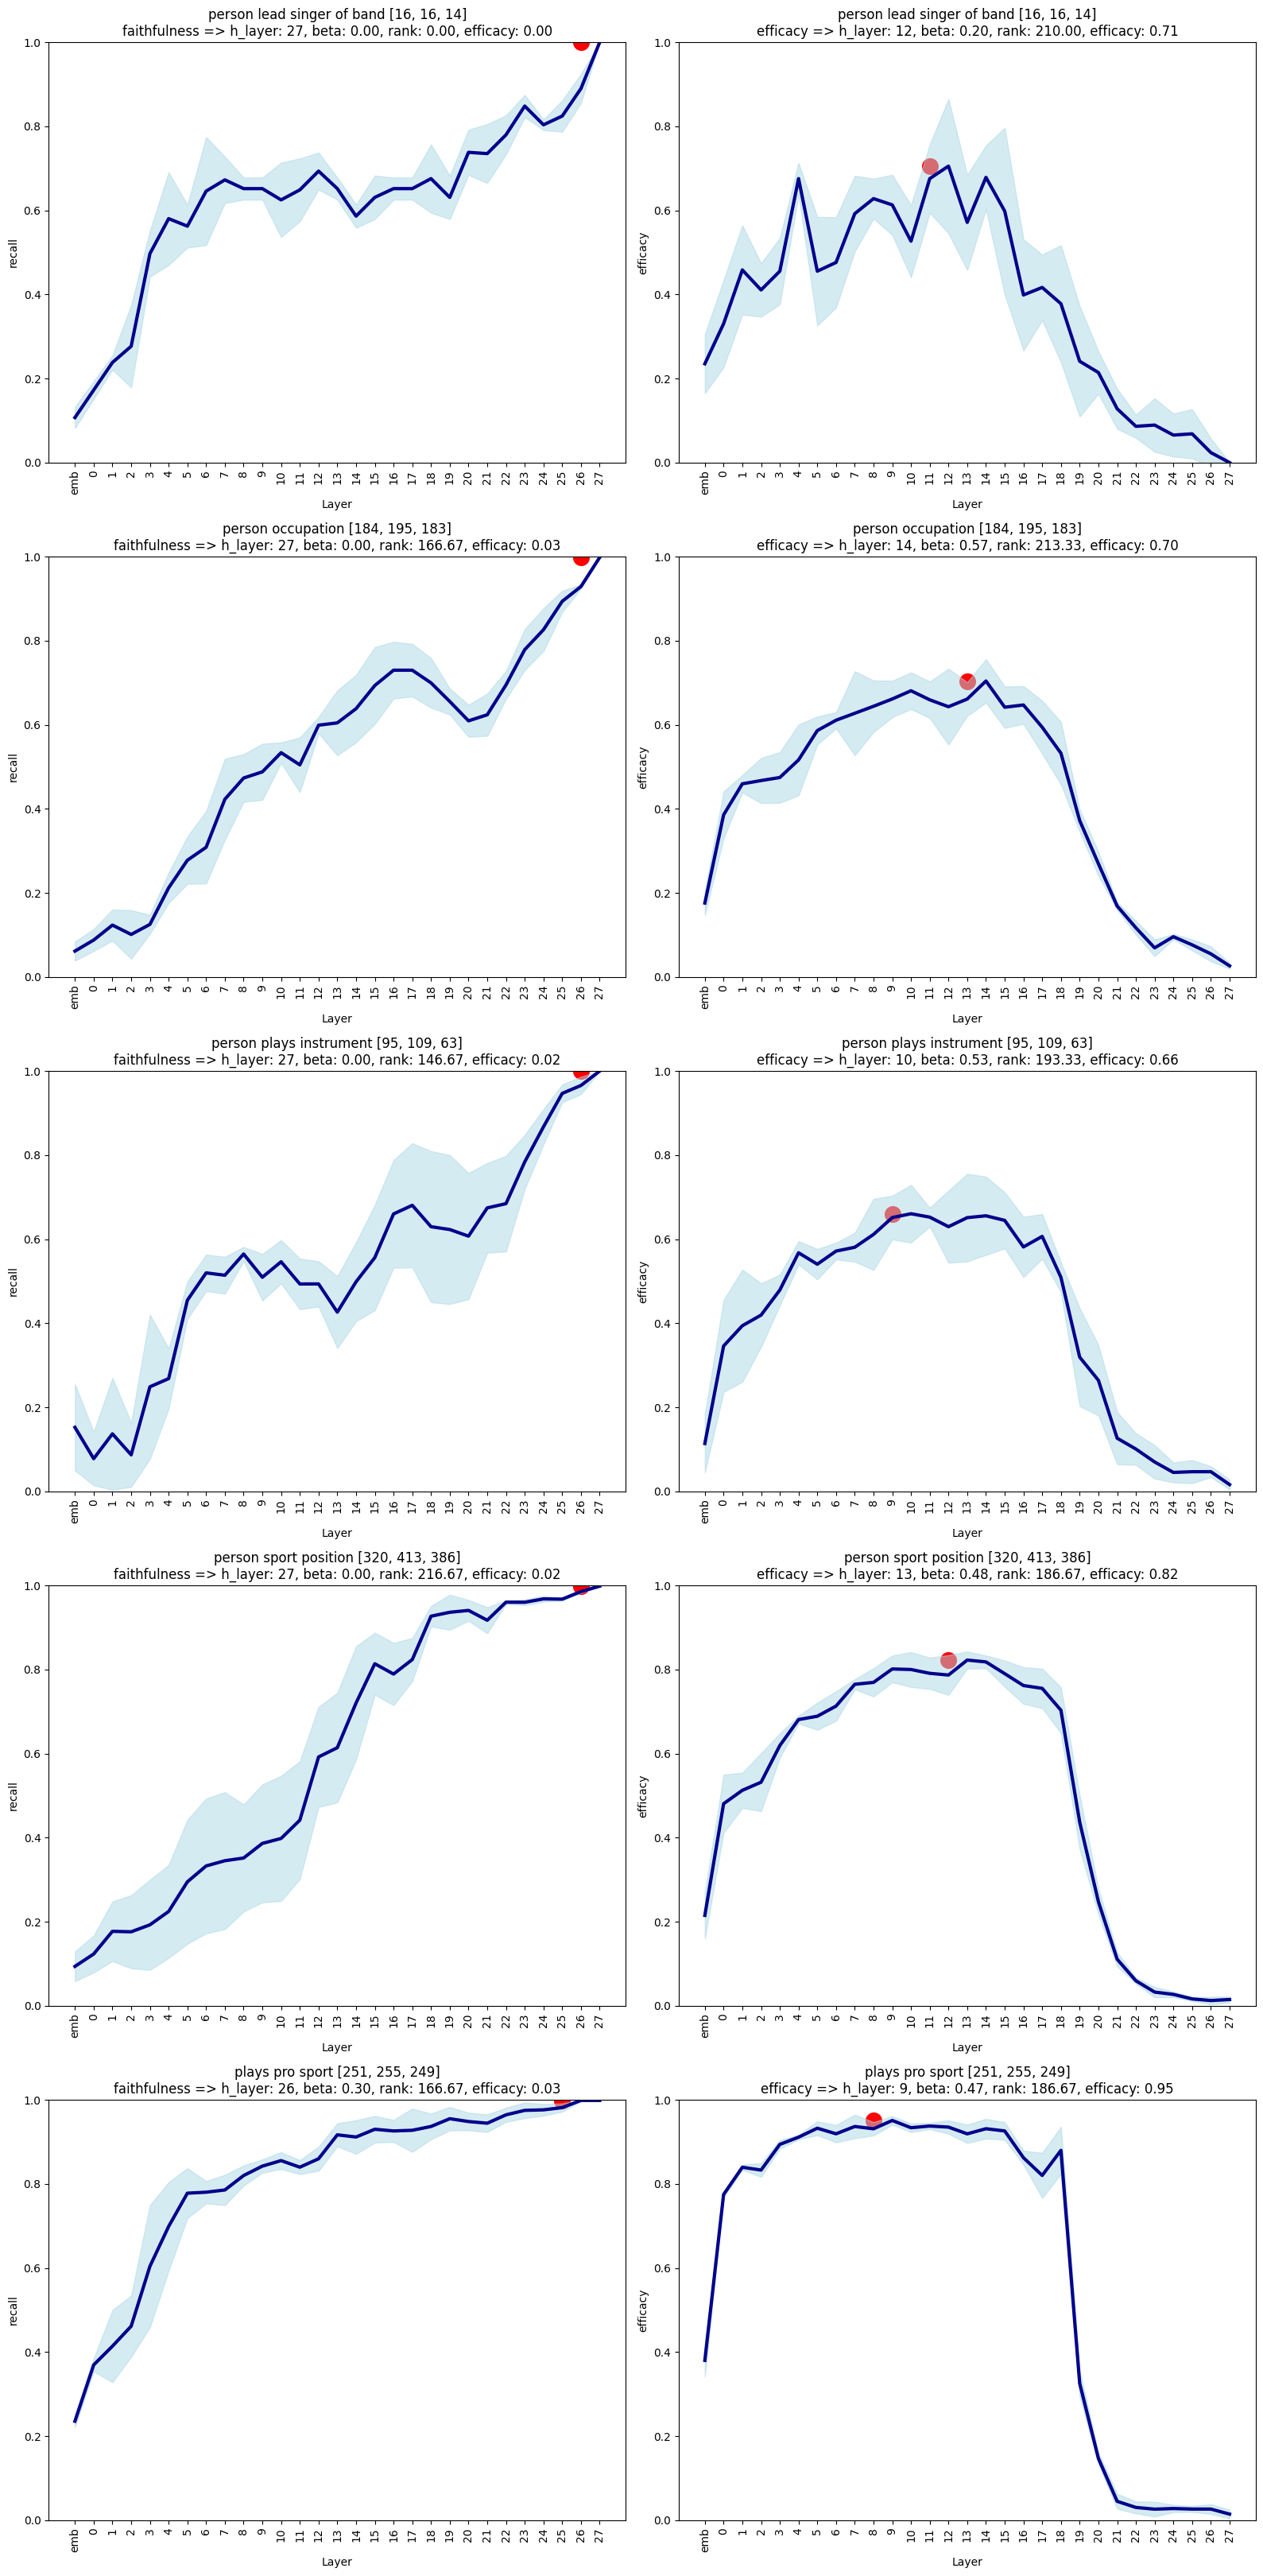

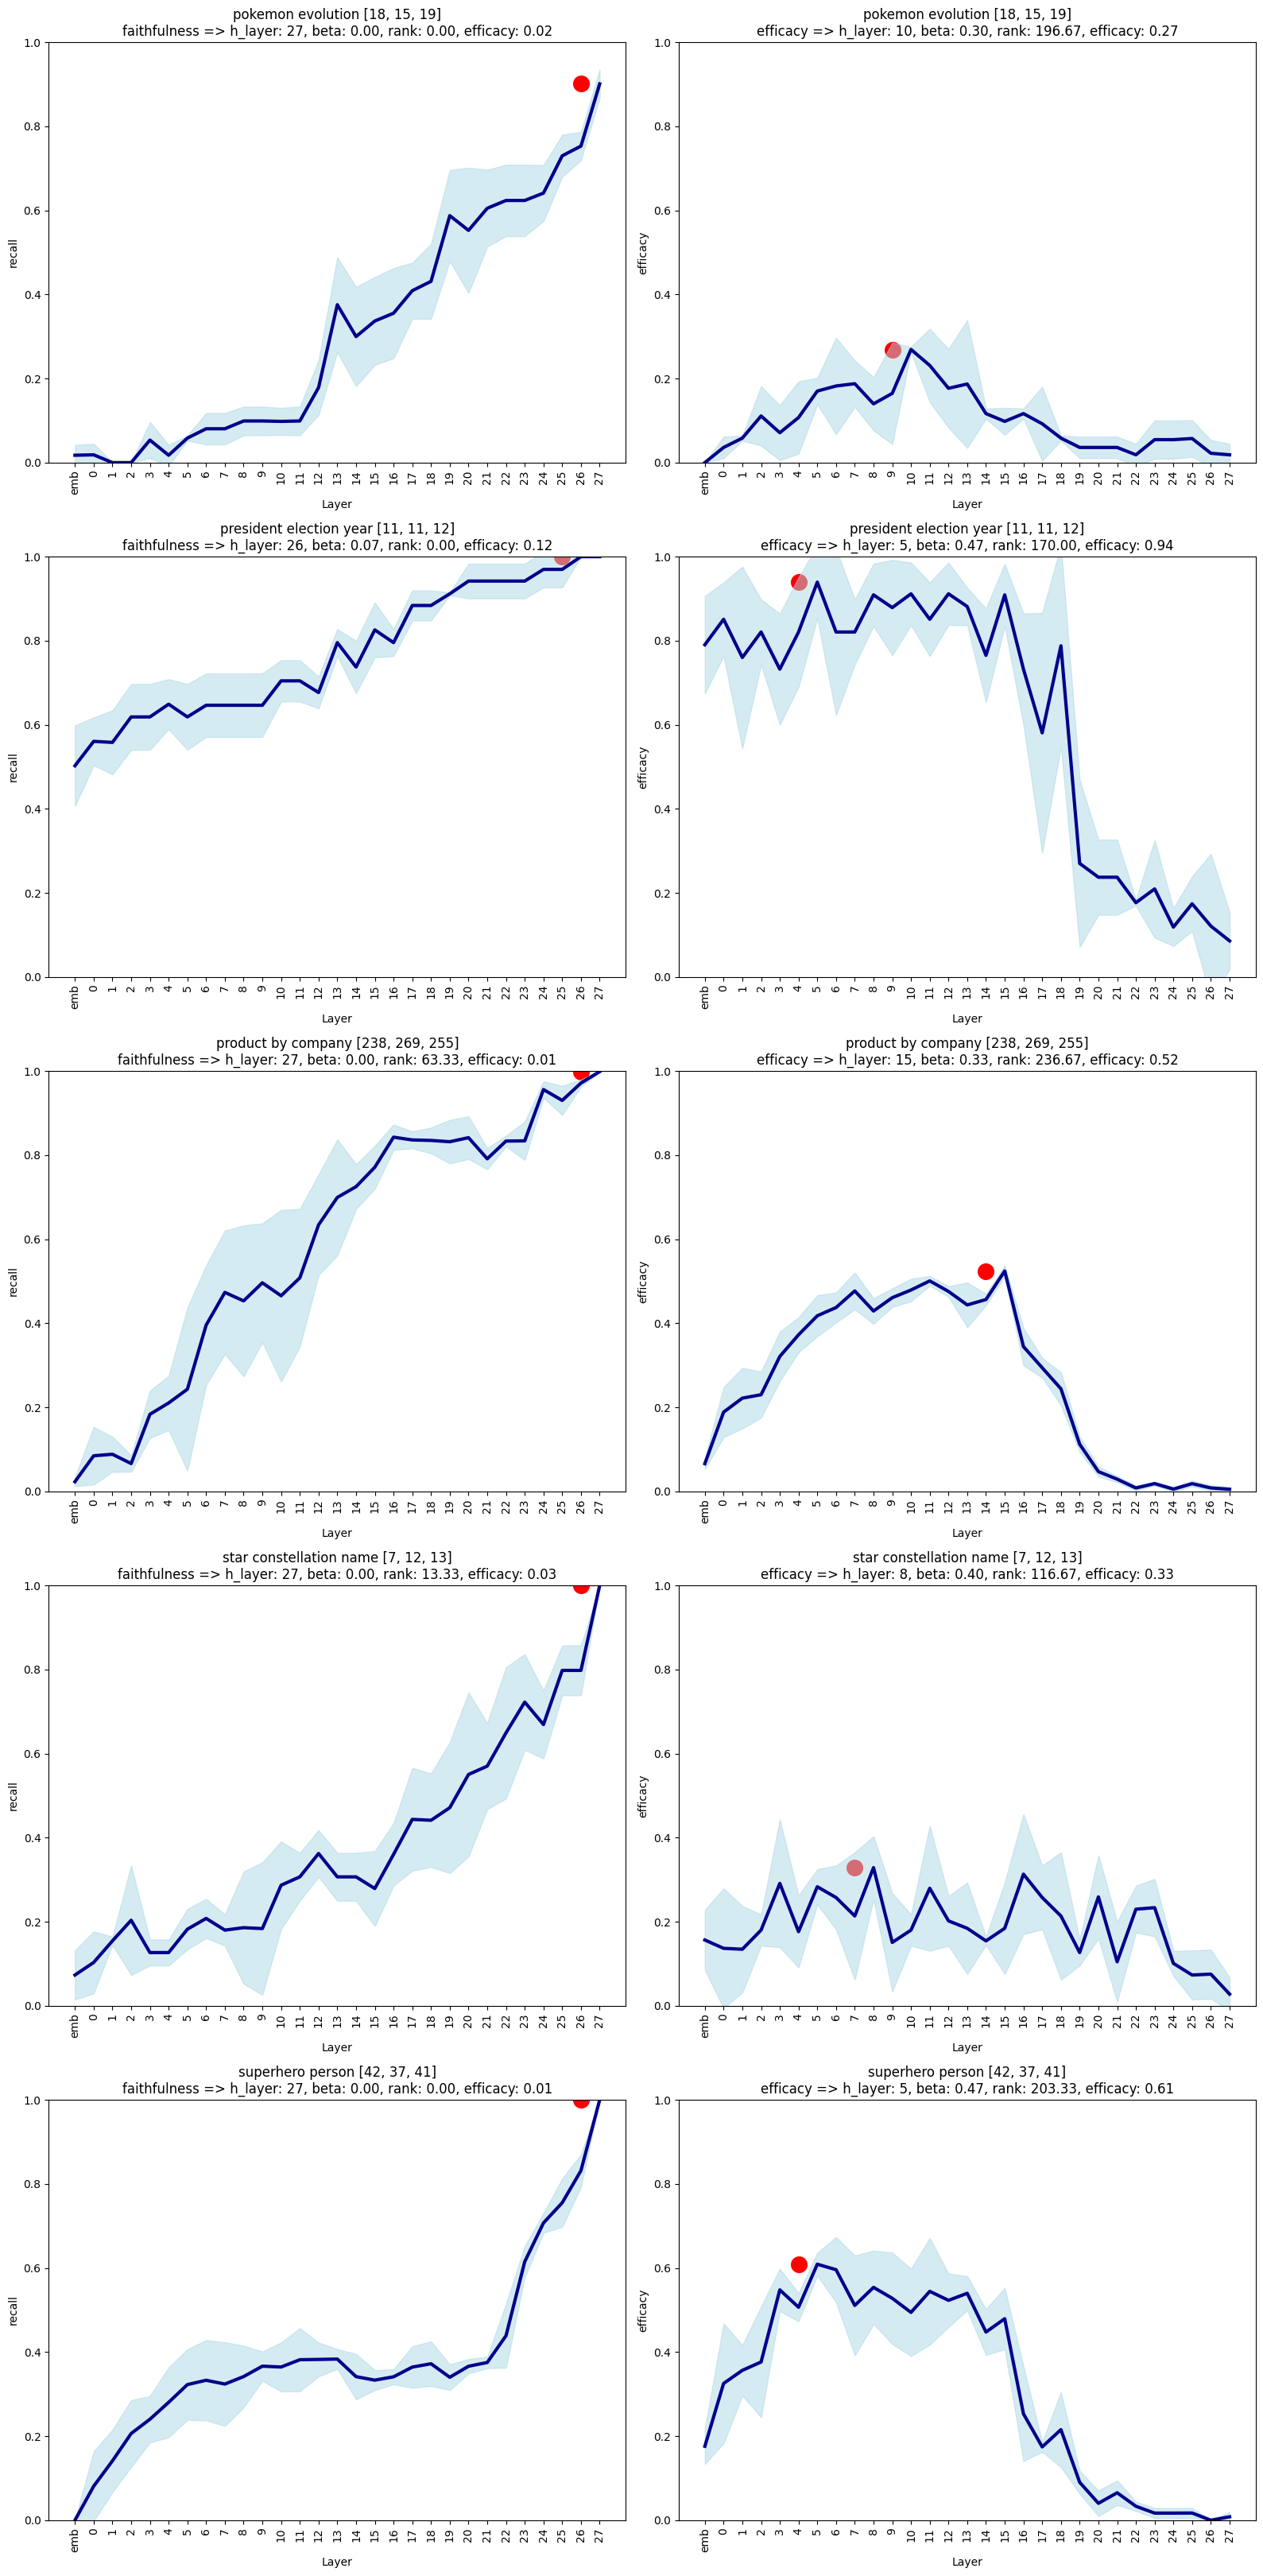

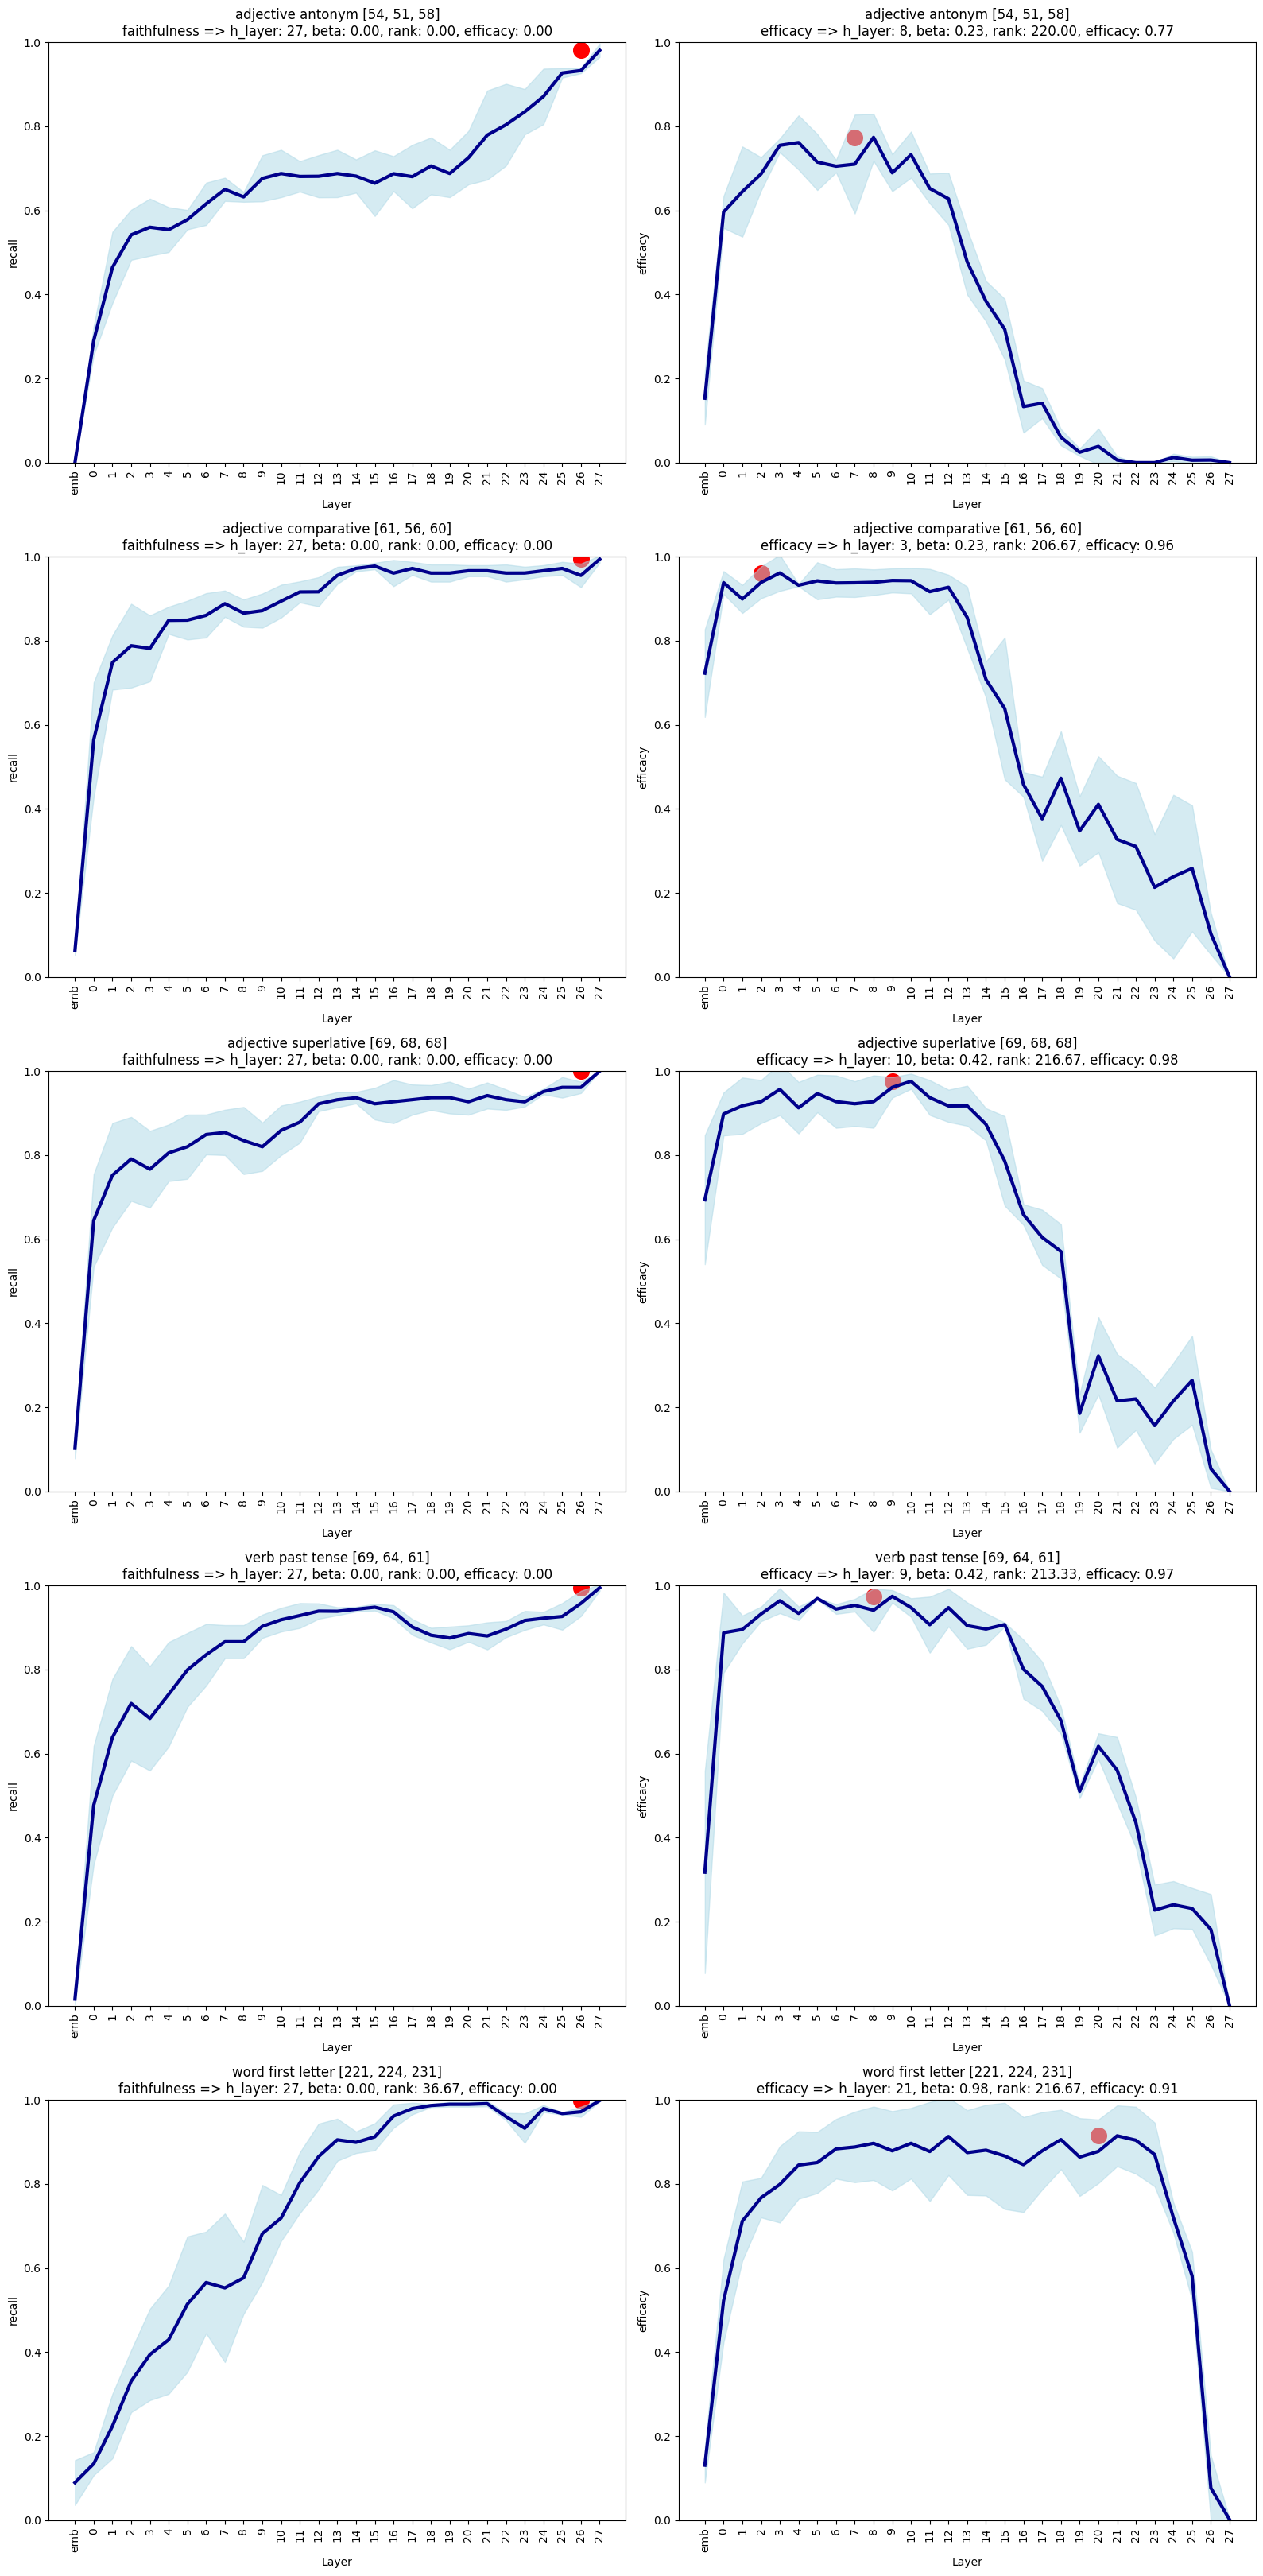

In [19]:
step_size = 5

for _from in range(0, len(filtered_results), step_size):
    _to = min(len(filtered_results), _from + step_size)
    n_subplots = len(filtered_results) * 3
    n_subplots = (_to - _from)  * 2
    ncols=2
    nrows=int(np.ceil(n_subplots/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 6.5))
    if n_subplots == 1:
        axes = [axes]
    if nrows == 1:
        axes = [axes]

    ax_col, ax_row = 0, 0
    for i, (relation_name, relation_result) in list(enumerate(filtered_results.items()))[_from  : _to]:
        print(i, relation_name)
        # result = parse_results(sweep_results[relation_name])
        result = filtered_results[relation_name]
        plot_layerwise(axes[ax_row][0], result)
        plot_layerwise(axes[ax_row][1], result, attribute="efficacy", best_criterion="efficacy")
        # if(relation_name in efficacy_baseline_results):
        #     efficacy_baselines = parse_efficacy_baseline_results(efficacy_baseline_results[relation_name])
        #     plot_efficacy_baseline(axes[ax_row][1], efficacy_baselines)
        # plot_layerwise(axes[ax_row][2], result, attribute="jh_norm", best_criterion="efficacy")
        ax_row += 1
        # break
    fig.tight_layout()
    fig.show()

In [24]:
sweep_path = f"../../results/sweep/{model_name}"

efficacy_baseline_results = read_sweep_results(sweep_path)

In [25]:
for relation in efficacy_baseline_results:
    efficacy_baseline_results[relation] = parse_results(efficacy_baseline_results[relation])

In [38]:
efficacy_baseline_results.keys()

dict_keys(['person occupation', 'landmark in country', 'adjective antonym', 'person mother', 'country capital city', 'plays pro sport', 'person plays instrument', 'person university', 'city in country', 'food from country', 'company hq', 'occupation gender', 'name gender', 'word first letter', 'country language', 'object superclass', 'name religion', 'president election year', 'fruit outside color', 'superhero archnemesis', 'work location', 'person lead singer of band', 'task person type', 'country largest city', 'country currency', 'fruit inside color', 'task done by tool', 'verb past tense', 'star constellation name', 'pokemon evolution', 'product by company', 'name birthplace', 'word last letter', 'word sentiment', 'company CEO', 'superhero person', 'person father', 'substance phase of matter', 'person sport position', 'adjective superlative', 'adjective comparative'])

In [56]:
def get_recall_vs_efficacy_info(sweep_results, criterion = "best", threshold = 30):
    recalls = []
    efficacies = []
    pass_threshold = []
    for relation_name in sweep_results:
        if len(sweep_results[relation_name].trials) == 0:
            continue
        if criterion in ["best", "faithfulness"]:
            recalls.append(sweep_results[relation_name].best_by_faithfulness().recall.mean)
        else:
            recalls.append(sweep_results[relation_name].best_by_efficacy().recall.mean)
        if criterion in ["best", "efficacy"]:
            efficacies.append(sweep_results[relation_name].best_by_efficacy().efficacy.mean)
        else:
            efficacies.append(sweep_results[relation_name].best_by_faithfulness().efficacy.mean)
        
        test_samples = np.array([trial.n_test_samples for trial in sweep_results[relation_name].trials])
        pass_threshold.append(test_samples.min() >= threshold)

    return recalls, efficacies, pass_threshold

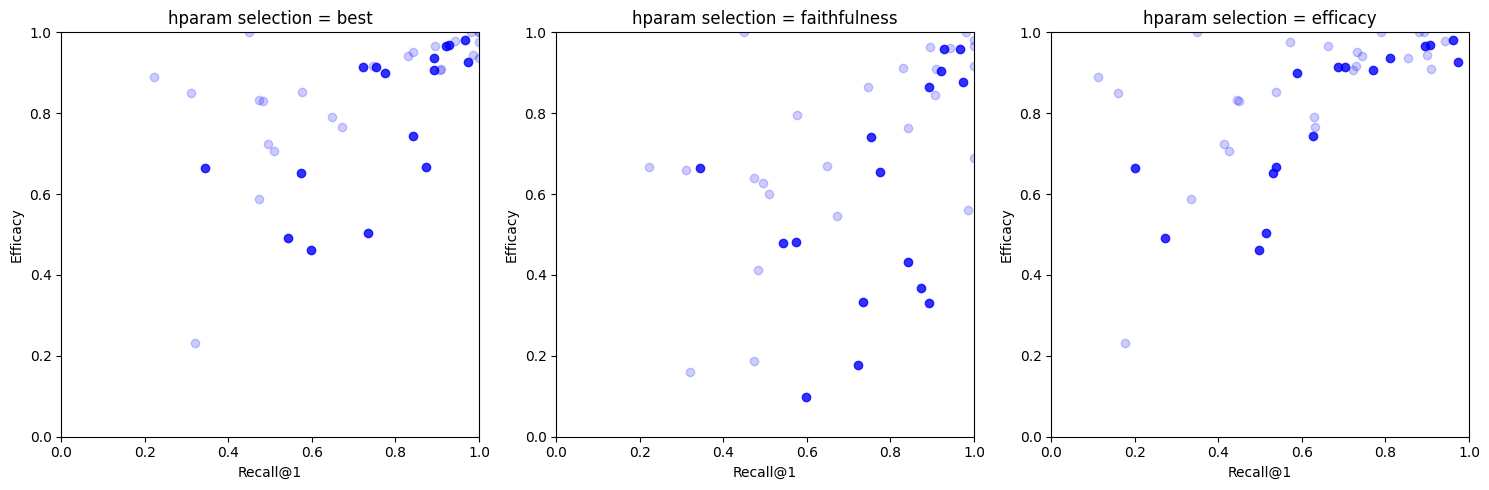

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for criterion, ax in zip(["best", "faithfulness", "efficacy"], axes):
    recalls, efficacies, pass_threshold = get_recall_vs_efficacy_info(efficacy_baseline_results, criterion=criterion)
    for r, e, p in zip(recalls, efficacies, pass_threshold):
        alpha = .8 if p else 0.2
        ax.scatter(r, e, color="blue", alpha=alpha)

    ax.set_title(f"hparam selection = {criterion}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Recall@1")
    ax.set_ylabel("Efficacy")

fig.tight_layout()
fig.show()

In [28]:
def read_and_parse_sweep_results(sweep_path):
    sweep_results = read_sweep_results(sweep_path)
    for relation in sweep_results:
        sweep_results[relation] = parse_results(sweep_results[relation])
    return sweep_results

In [29]:
sweep_single_path = f"../../results/sweep-single/{model_name}"
sweep_single = read_and_parse_sweep_results(sweep_single_path)

sweep_multi_path = f"../../results/sweep-multi/{model_name}"
sweep_multi = read_and_parse_sweep_results(sweep_multi_path)

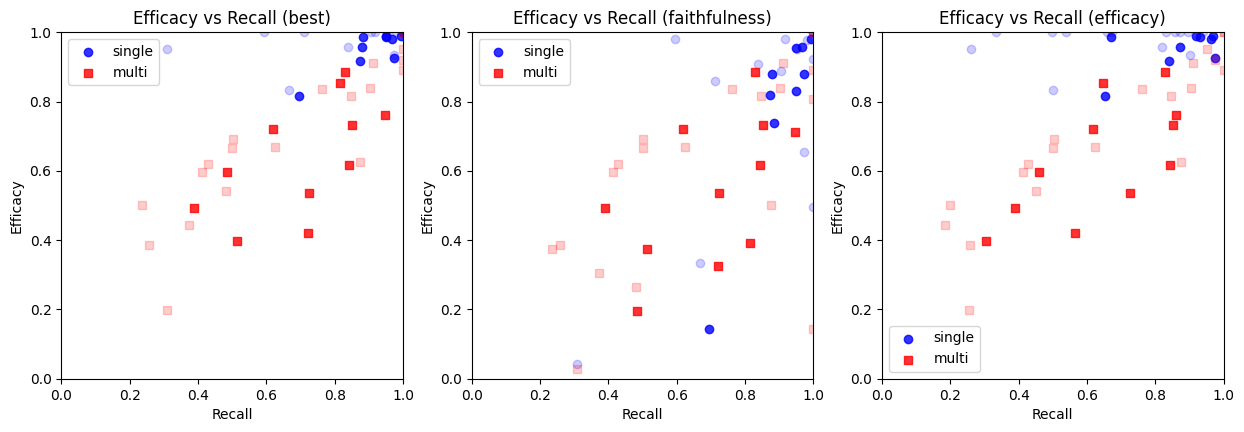

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4.5))

for criterion, ax in zip(["best", "faithfulness", "efficacy"], axes):
    single_recalls, single_efficacies, pass_single = get_recall_vs_efficacy_info(sweep_single, criterion=criterion)
    multi_recalls, multi_efficacies, pass_multi = get_recall_vs_efficacy_info(sweep_multi, criterion=criterion)
    labeled = False
    for r, e, p in zip(single_recalls, single_efficacies, pass_single):
        alpha = .8 if p else 0.2
        if (alpha == 0.8 and not labeled):
            ax.scatter(r, e, color = "blue", label = "single", alpha = alpha)
            labeled = True
        else:
            ax.scatter(r, e, color = "blue", alpha = alpha)

    labeled = False
    for r, e, p in zip(multi_recalls, multi_efficacies, pass_multi):
        alpha = .8 if p else 0.2
        alpha = .8 if p else 0.2
        if (alpha == 0.8 and not labeled):
            ax.scatter(r, e, color = "red", label = "multi", marker = "s", alpha = alpha)
            labeled = True
        else:
            ax.scatter(r, e, color = "red", marker = "s", alpha = alpha)

    ax.set_title(f"Efficacy vs Recall ({criterion})")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Efficacy")
    ax.legend()

In [74]:
from src import models

In [75]:
mt = models.load_model(name = "gptj", fp16=True, device="cuda")

In [76]:
mt.tokenizer(" :")

{'input_ids': [1058], 'attention_mask': [1]}